In [1]:
%load_ext autoreload
%autoreload 2
from hmpai.pytorch.utilities import *
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.normalization import *
from hmpai.visualization import *
from pathlib import Path
import xarray as xr
from hmpai.data import preprocess
from captum.attr import IntegratedGradients
from mne.io import read_info

In [12]:
set_global_seed(42)
data_path = Path("../data/sat1/split_stage_data_100hz.nc")
dataset = xr.load_dataset(data_path)
train_data, val_data, test_data = split_data_on_participants(dataset, 60, norm_min1_to_1)
chk_path = Path("../models/gru100/checkpoint.pt")
positions = read_info(Path("../data/sat1/preprocessed/processed_0001_epo.fif"))

In [13]:
checkpoint = load_model(chk_path)

In [14]:
# RNN cannot be used in eval mode with cuDNN enabled
torch.backends.cudnn.enabled = False
model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE).eval()

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


SAT1GRU(
  (relu): ReLU()
  (gru): GRU(30, 128, batch_first=True, dropout=0.25)
  (linear): LazyLinear(in_features=0, out_features=64, bias=True)
  (linear_final): LazyLinear(in_features=0, out_features=5, bias=True)
)

In [15]:
ig = IntegratedGradients(model.forward)

In [16]:
attributions = add_attribution(test_data, ig, model)

  0%|          | 0/126 [00:00<?, ?it/s]

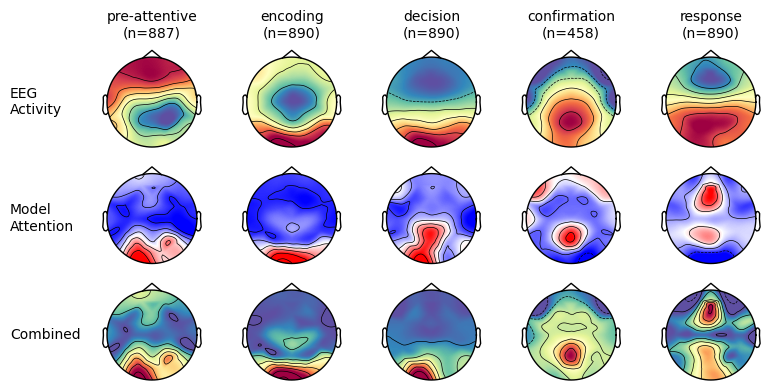

In [25]:
plot_max_activation_per_label(attributions, positions, save=True)


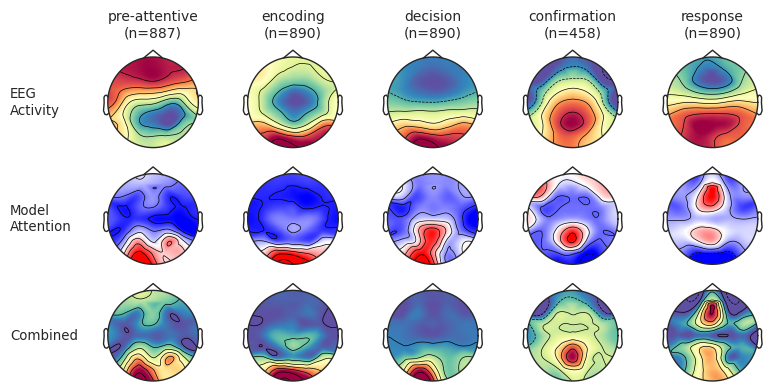

In [31]:
plot_max_activation_per_label(attributions, positions, save=True)

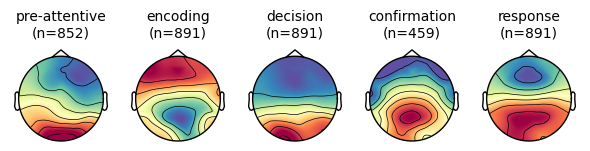

In [15]:
plot_mean_activation_per_label(attributions, positions)

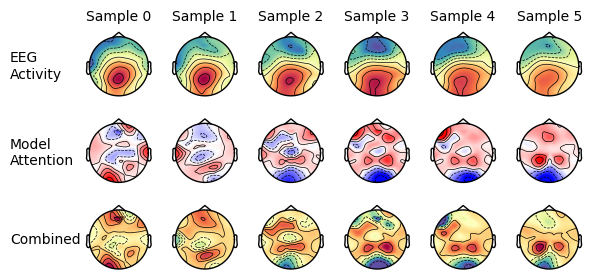

In [18]:
plot_single_trial_activation(attributions.isel(index=1), positions)

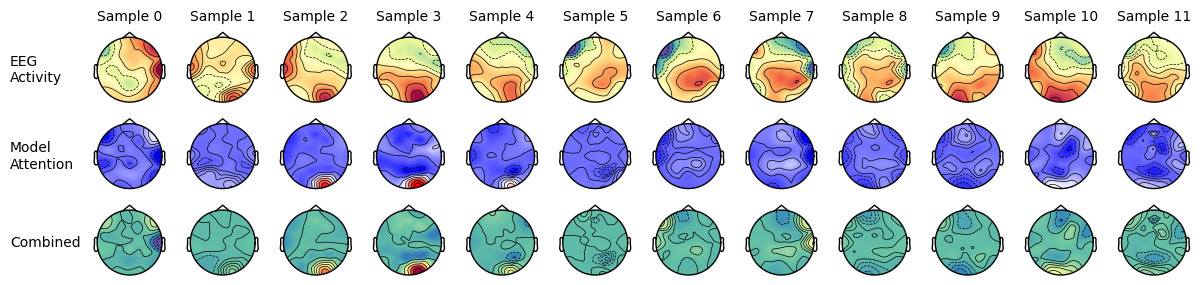

In [19]:
plot_single_trial_activation(attributions.isel(index=3), positions)

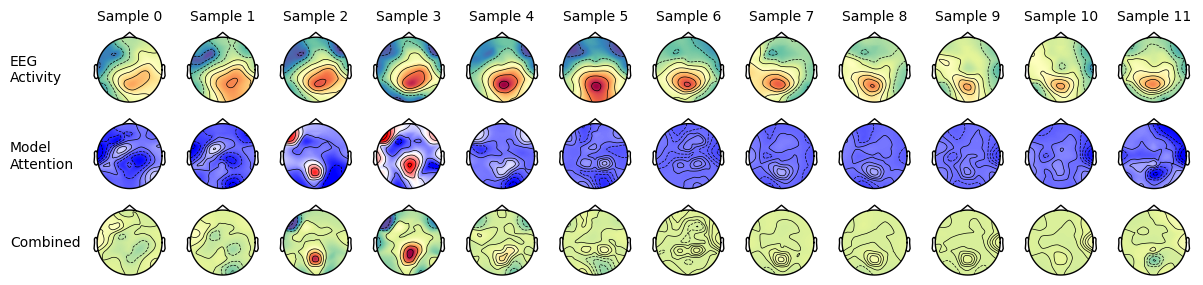

In [20]:
plot_single_trial_activation(attributions.isel(index=5), positions)

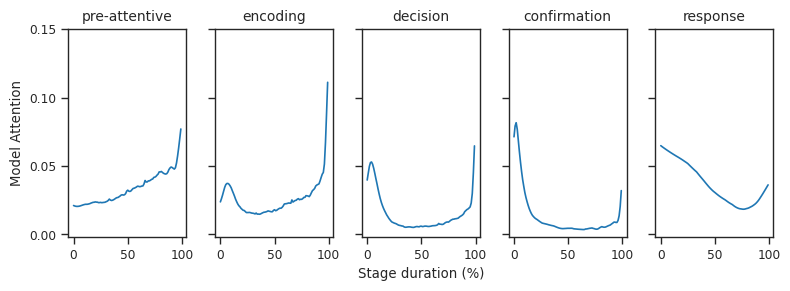

In [32]:
plot_model_attention_over_stage_duration(attributions, save=True)